# MIS problem for new Starbucks cafes allocation in Toronto.  Analysis of the possibilities of quantum computing to solve the problem.

Suppose a company wants to allocate some new cafes in a chosen area of a certain city. The company has several options but it is very unlogic to set the cafe on every point. Instead, they formulate a task to solve, namely: 

**To allocate as many cafes as possible in such a way they will not compete for the clients.** 

The problem can be formulated as the Maximum Independent Set one, which is considered to be an NP-hard problem and for large dimensions, the classical computer might be not successful in solving it. 

In this notebook we would like to show how Bloqade package can simulate the corresponding quantum system and how the performance on this model can be estimated. 

In [1]:
# Before we would like to show the problem on a real map
using Pkg
pkg"add OpenStreetMapX, OpenStreetMapXPlot, Parameters, PyCall, Conda, Colors, CSV, DataFrames, LightGraphs, DataStructures"
using Conda
Conda.runconda(`install folium -c conda-forge --yes`)

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
┌ Info: Running `conda install folium -c conda-forge --yes` in root environment
└ @ Conda /home/vasily/.julia/packages/Conda/x2UxR/src/Conda.jl:127


Solving environment: ...working... done

# All requested packages already installed.



In [2]:
using Random, Parameters, OpenStreetMapX, LightGraphs, PyCall, CSV, DataFrames, SparseArrays, LightGraphs, DataStructures
using Plots
ENV["GKSwstype"]="nul"  # this parameter significantly speeds up generation of GR-based plots
gr()
using OpenStreetMapXPlot
const flm = pyimport("folium");

In [3]:
pwd()  # use this to to check in which folder you are, the folder should contain the torontoF.osm 

"/home/vasily/Desktop/CDL"

In [4]:
m = get_map_data("central_torontoF.osm", use_cache=false, trim_to_connected_graph=true );
typeof(m)

MapData

In [5]:
?MapData

search: MapData get_map_data



The `MapData` represents all data that have been processed from OpenStreetMap osm file This is the main data structure used fot map data analytics.

**Fields**

  * `bounds` :  bounds of the area map (stored as a OpenStreetMapX.Bounds object)
  * `nodes` :  dictionary of nodes representing all the objects on the map (with coordinates in East, North, Up system)
  * `roadways` :  unique roads stored as a OpenStreetMapX.Way objects
  * `intersections` : roads intersections
  * `g` : `Graphs` directed graph representing a road network
  * `v` : vertices in the road network (node id .=> graph vertex)
  * `n` : vector of OpenStreetMap node ids for each corresponding graph vertex
  * `e` : vector of edges in the graph represented as a tuple (source,destination)
  * `w` : sparse matrix of edge weights, indexed by graph id
  * `class` : road class of each edge

---

Internal constructor of `MapData` object


In [6]:
ttc_locs = [LLA(m.nodes[m.n[t]],m.bounds) for t in [1,12,34,44,67,101]]

6-element Vector{LLA}:
 LLA(43.6563366, -79.380915, 0.0)
 LLA(43.65306750000001, -79.3877432, 9.313225746154785e-10)
 LLA(43.6488807, -79.385519, 0.0)
 LLA(43.6564095, -79.3841351, 0.0)
 LLA(43.65287899999999, -79.377134, -9.313225746154785e-10)
 LLA(43.6452942, -79.3788783, -9.313225746154785e-10)

We use some points on the map of Toronto as possible places where new cafes may be opened. Morever, we define an area for which the problem is solved and different edges for the graph. 

In [9]:
fm = flm.Map()

# nrow(ttc)
# end-7+t
ttc_locs = [LLA(m.nodes[m.n[t]],m.bounds) for t in [1,12,34,44,67,101]]

flm.PolyLine(        
#         [(loc.lat, loc.lon) for loc in ttc_locs ],
        [( ttc_locs[3].lat,  ttc_locs[3].lon) , ( ttc_locs[6].lat,  ttc_locs[6].lon),
        ( ttc_locs[6].lat,  ttc_locs[6].lon),( ttc_locs[5].lat,  ttc_locs[5].lon),
        ( ttc_locs[5].lat,  ttc_locs[5].lon),( ttc_locs[1].lat,  ttc_locs[1].lon),
        ( ttc_locs[1].lat,  ttc_locs[1].lon),( ttc_locs[4].lat,  ttc_locs[4].lon),
        ( ttc_locs[4].lat,  ttc_locs[4].lon),( ttc_locs[2].lat,  ttc_locs[2].lon),
        ( ttc_locs[2].lat,  ttc_locs[2].lon),( ttc_locs[3].lat,  ttc_locs[3].lon),
        ( ttc_locs[3].lat,  ttc_locs[3].lon),( ttc_locs[5].lat,  ttc_locs[5].lon)],
        color="red",
        opacity=0.2,
    weight=25
    
    ).add_to(fm)
for loc in ttc_locs
    flm.Circle((loc.lat, loc.lon), color="",
        fill_color="red", fill_opacity=0.35).add_to(fm)
end

MAP_BOUNDS = [(m.bounds.min_y,m.bounds.min_x),(m.bounds.max_y,m.bounds.max_x)]
flm.Rectangle(MAP_BOUNDS, color="black",weight=6).add_to(fm)
fm.fit_bounds(MAP_BOUNDS)
fm

PyObject <folium.folium.Map object at 0x7f92041579a0>

## Solution of the problem with a quantum computer

For the given map we can easily create a corresponding *Graph* object for Bloqade package and see what results we may obtain for the given task. 

In [1]:
using Graphs
using Bloqade
using Compose
using Random
using GenericTensorNetworks
using Optim
using PythonCall
plt = pyimport("matplotlib.pyplot");

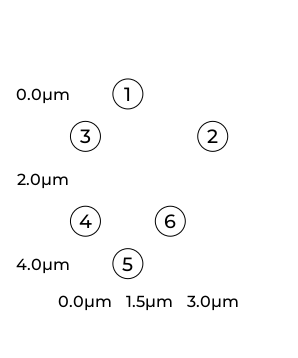

In [17]:
atom_coordinate = AtomList([(1, 0), (3, 1), (0, 1), (0, 3),(1,4),(2,3)])

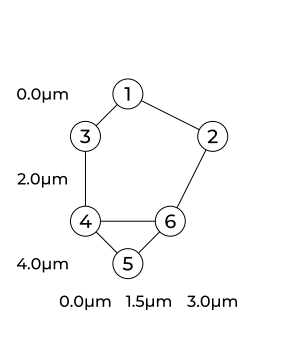

In [18]:
Bloqade.plot(atom_coordinate, blockade_radius = 2.7)

In [19]:
graph = BloqadeMIS.unit_disk_graph(atom_coordinate, 2.7)
mis_size_and_counting = GenericTensorNetworks.solve(IndependentSet(graph), CountingMax())[]

(3.0, 1.0)ₜ

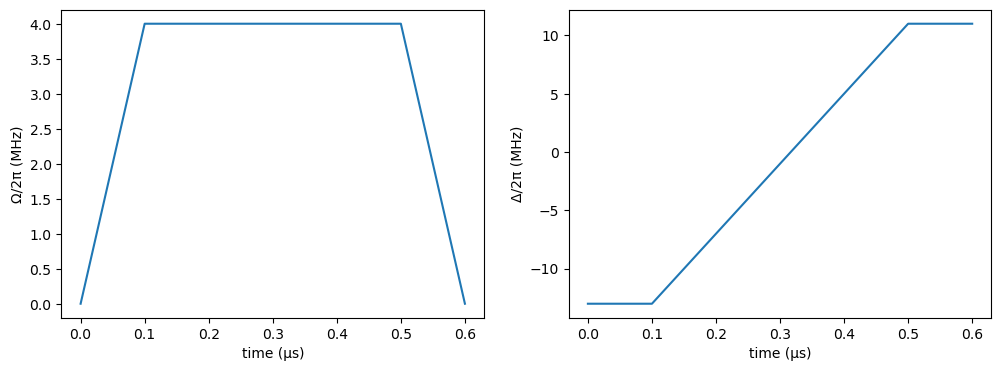

In [20]:
# we use simple pulse parametrization here
T_max = 0.6
Ω_max = 2π * 4
Ω = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [0.0, Ω_max, Ω_max, 0])
Δ_start = -2π * 13
Δ_end = 2π * 11
Δ = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [Δ_start, Δ_start, Δ_end, Δ_end])

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

In [22]:
hamiltonian = rydberg_h(atom_coordinate; Ω = Ω, Δ = Δ)
prob = SchrodingerProblem(zero_state(nqubits(hamiltonian)), T_max, hamiltonian)
emulate!(prob)

SchrodingerProblem:
  register info:
    type: ArrayReg{2, ComplexF64, Matrix{ComplexF64}}
    storage size: 8 bytes

  time span (μs): (0.0, 0.6)

  equation: 
    storage size: 6.523 KiB
    expression:
nqubits: 6
+
├─ [+] ∑ 2π ⋅ 8.627e6.0/|r_i-r_j|^6 n_i n_j
├─ [+] Ω(t) ⋅ ∑ σ^x_i
└─ [-] Δ(t) ⋅ ∑ n_i


  options:
    save_everystep: false
    save_start: false
    save_on: false
    dense: false


In [23]:
best_bit_strings = most_probable(prob.reg, 2)
best_bit_strings[1]

010000 ₍₂₎

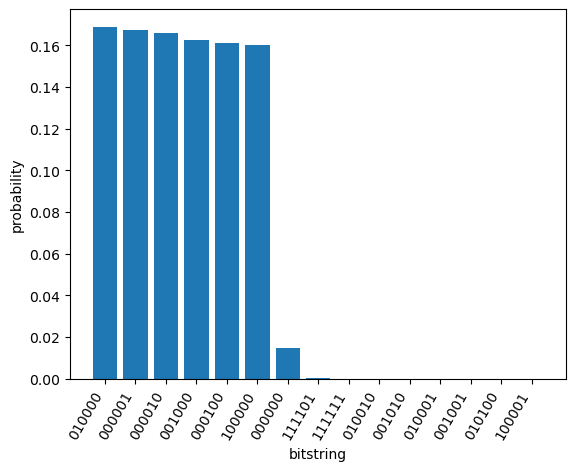

In [24]:
bitstring_hist(prob.reg; nlargest = 15)

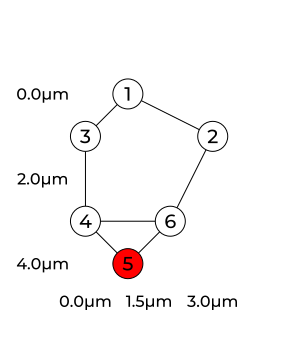

In [25]:
Bloqade.plot(atom_coordinate, blockade_radius = 2.7; 
    colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[1]])

As we can see, the simulations for the problem were not so successful even for the very simple model and perhaps different approaches shoud be used here.

**But now Starbacks know how quantum algorithms can be implemented for their opeartions!** 